# IMA206-projet: Self-supervised learning for medical image classification

# SimCLR:

## To do for next week-0614:
- 用test dataset做最后的结果比较 （Validation dataset 训练时可以按paper里用上early-stopping）
- 图片导入： 用64*64 （以匹配ResNet18）
- Linear probing (using pytorch，不要用sklearn)
- 借助Visualization (Pretrain部分的t-SNE和Fine tuning的Confusion Matrix) 分析结果和数据情况
## shi山使用说明
- 在混淆矩阵部分 我重写了部分代码。 因为X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)  这句代码是没有根据的。

---

In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117031 sha256=d38eff203720ab54b9b0e628c0e22c9808272a1de7ca32d361b8ed6196bf390f
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [2]:
import medmnist
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

In [3]:
# Load the dataset
data_flag = 'pathmnist'
download = True

# Get dataset information
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

'''
class Rotate90orMinus90:
    def __call__(self, x):
        if random.random() > 0.5:
            return transforms.functional.rotate(x, 90)
        else:
            return transforms.functional.rotate(x, -90)
'''
import torchvision.transforms.functional as TF
class RotateRandom:
    def __call__(self, x):
        angles = [0, 90, 180, 270]
        angle = random.choice(angles)
        return TF.rotate(x, angle)


PathMNIST_MEAN = [0.73765225, 0.53090023, 0.70307171]
PathMNIST_STD = [0.12319908, 0.17607205, 0.12394462]


# Define transformations for data augmentation
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),  # random resized crop  # 64
    transforms.RandomHorizontalFlip(p=0.5),  # random horizontal flip
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),  # random gaussian blur, changed kernel_size from 23 to 7
    RotateRandom(),  # random rotate 90 or -90
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=PathMNIST_MEAN, std=PathMNIST_STD) # normalize
])


org_data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=[.5], std=[.5]) # normalize
])


In [4]:
org_train_dataset = DataClass(split='train', transform= org_data_transform , download=download, size=64)
aug_train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)

100%|██████████| 1069422170/1069422170 [00:09<00:00, 110191089.53it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist_64.npz


In [5]:
from torch.utils.data import Dataset

class PairedDataset(Dataset):
    def __init__(self, org_dataset, aug_dataset):
        self.org_dataset = org_dataset
        self.aug_dataset = aug_dataset
        assert len(org_dataset) == len(aug_dataset), "Datasets must be of the same length"

    def __len__(self):
        return len(self.org_dataset)

    def __getitem__(self, idx):
        org_image, _ = self.org_dataset[idx]
        aug_image, _ = self.aug_dataset[idx]
        return org_image, aug_image


paired_dataset = PairedDataset(org_train_dataset, aug_train_dataset)
train_loader = DataLoader(paired_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

In [6]:
org_val_dataset = DataClass(split='val', transform=org_data_transform, download=download, size=64)
aug_val_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)

val_paired_dataset = PairedDataset(org_val_dataset, aug_val_dataset)

val_loader = DataLoader(dataset=org_val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

Using downloaded and verified file: /root/.medmnist/pathmnist_64.npz
Using downloaded and verified file: /root/.medmnist/pathmnist_64.npz


In [7]:
# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLR, self).__init__()
        self.encoder = self.get_resnet(base_model)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def get_resnet(self, base_model):
        model = models.__dict__[base_model](pretrained=False)
        model = nn.Sequential(*list(model.children())[:-1])
        return model

    def forward(self, x):
        h = self.encoder(x)
        h = h.squeeze()
        z = self.projector(h)
        return h, z

model = SimCLR(base_model='resnet18', out_dim=128).cuda()   # output dimension = 128

# Define the NT-Xent Loss function
class NT_XentLoss(nn.Module):
    def __init__(self, temperature):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        mask = self.mask_correlated_samples(batch_size)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        negatives = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positives.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        loss = self.criterion(logits, labels)
        # print(labels)
        return loss / N

criterion = NT_XentLoss(temperature=0.5).cuda()   # temperature

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
num_epochs = 50

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (org_images,aug_images) in enumerate(train_loader):
            org_images = org_images.cuda()
            aug_images = aug_images.cuda()
            
            z_i = model(org_images)
            z_j = model(aug_images)
            
            if isinstance(z_i, tuple):
                z_i = z_i[0]
            if isinstance(z_j, tuple):
                z_j = z_j[0]
            
            loss = criterion(z_i, z_j)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(train_loader)

In [9]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    print(f'Epoch {epoch}, Train Loss: {train_loss}')

# Save features for evaluation
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h, _ = model(data)
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

save_features(model, val_loader, 'pathmnist_features_ep_50.npz')

Epoch 0, Batch 0, Loss: 6.151629447937012
Epoch 0, Batch 10, Loss: 5.251284599304199
Epoch 0, Batch 20, Loss: 5.037685871124268
Epoch 0, Batch 30, Loss: 4.9242634773254395
Epoch 0, Batch 40, Loss: 4.854162216186523
Epoch 0, Batch 50, Loss: 4.788380146026611
Epoch 0, Batch 60, Loss: 4.748604774475098
Epoch 0, Batch 70, Loss: 4.700155258178711
Epoch 0, Batch 80, Loss: 4.672607421875
Epoch 0, Batch 90, Loss: 4.631000518798828
Epoch 0, Batch 100, Loss: 4.6220011711120605
Epoch 0, Batch 110, Loss: 4.605020046234131
Epoch 0, Batch 120, Loss: 4.588672161102295
Epoch 0, Batch 130, Loss: 4.584521293640137
Epoch 0, Batch 140, Loss: 4.6072187423706055
Epoch 0, Batch 150, Loss: 4.617882251739502
Epoch 0, Batch 160, Loss: 4.564692974090576
Epoch 0, Batch 170, Loss: 4.575096130371094
Epoch 0, Batch 180, Loss: 4.580643653869629
Epoch 0, Batch 190, Loss: 4.561248302459717
Epoch 0, Batch 200, Loss: 4.549477577209473
Epoch 0, Batch 210, Loss: 4.595399856567383
Epoch 0, Batch 220, Loss: 4.568715572357178

## Display of visualization:

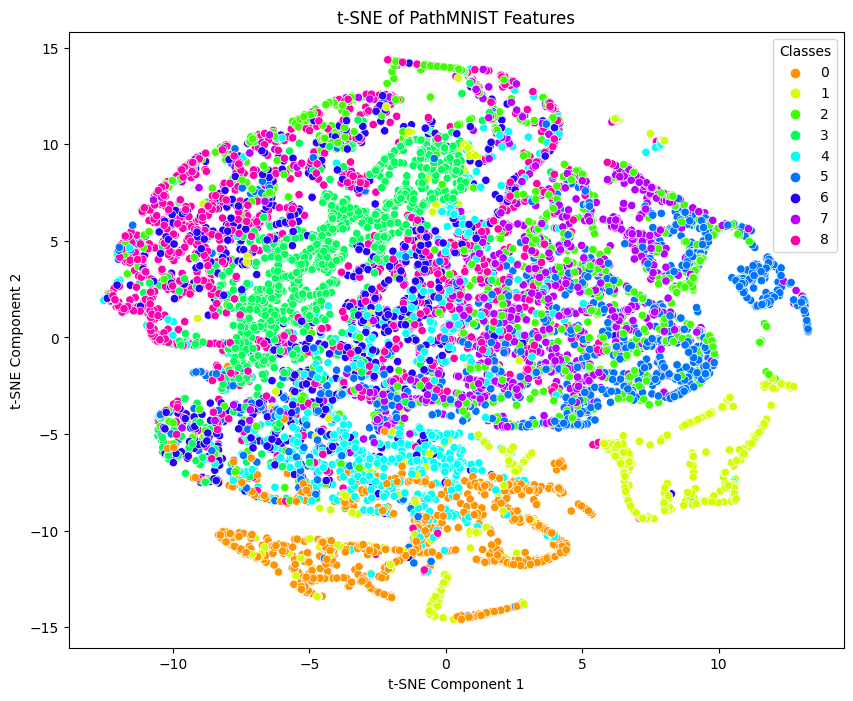

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features_ep_50.npz')
features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


### Validation:

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

'''
# Load features
data = np.load('pathmnist_features_ep_50.npz')
features = data['features']
labels = data['labels']

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Predict on validation set
y_pred = classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Save the model parameters
torch.save(model.state_dict(), 'simclr_model.pth')
'''
# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = correct / total
    return accuracy

#test_accuracy = evaluate(linear_probe_model, test_loader)
#print(f'Test Accuracy: {test_accuracy:.4f}')

class LinearProbeModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(LinearProbeModel, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits

# 加载预训练的 SimCLR 模型
encoder = SimCLR(base_model='resnet18', out_dim=128).encoder
linear_probe_model = LinearProbeModel(encoder, num_classes=9).cuda()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_probe_model.classifier.parameters(), lr=1e-4, weight_decay=1e-6)

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            logits = model(data)
            loss = criterion(logits, target)
            total_loss += loss.item()
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy

num_epochs = 50
best_val_accuracy = 0.0
best_model_weights = None
def get_sub_indices(dataset, proportion=0.01):
    class_indices = {}
    
    for i, data in enumerate(dataset): 
        class_idx = int(data[1][0])
        if class_idx not in class_indices:
            class_indices[class_idx] = []
        class_indices[class_idx].append(i)
    
    # List to store subset indices
    subset_indices = []
        
    # Choose proportionate indices from each class
    for indices in class_indices.values():
        selected_indices = np.random.choice(
            indices, 
            size=int(np.ceil(len(indices) * proportion)),
            replace=False
        ).tolist()  # Ensure indices are in a list format
        subset_indices.extend(selected_indices)

    return subset_indices

fine_tune_indices = get_sub_indices(org_train_dataset, proportion=1)
fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

for epoch in range(num_epochs):
    linear_probe_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer.zero_grad()
        logits = linear_probe_model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    if epoch % 10 == 0:
        val_loss, val_accuracy = validate(linear_probe_model, val_loader, criterion)
        print(f'Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = linear_probe_model.state_dict()

# 加载最佳模型权重
linear_probe_model.load_state_dict(best_model_weights)

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 在测试数据集上评估
test_accuracy = evaluate(linear_probe_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')


100%|██████████| 205615438/205615438 [00:01<00:00, 171177128.62it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0, Batch 0, Loss: 2.3658642768859863
Epoch 0, Batch 10, Loss: 2.2138924598693848
Epoch 0, Batch 20, Loss: 2.1577861309051514
Epoch 0, Batch 30, Loss: 2.1607096195220947
Epoch 0, Batch 40, Loss: 2.1147830486297607
Epoch 0, Batch 50, Loss: 2.1381783485412598
Epoch 0, Batch 60, Loss: 2.1192235946655273
Epoch 0, Batch 70, Loss: 2.065314292907715
Epoch 0, Batch 80, Loss: 2.0542101860046387
Epoch 0, Batch 90, Loss: 2.0699386596679688
Epoch 0, Batch 100, Loss: 2.0476036071777344
Epoch 0, Batch 110, Loss: 2.0234835147857666
Epoch 0, Batch 120, Loss: 1.9805431365966797
Epoch 0, Batch 130, Loss: 1.977622151374817
Epoch 0, Batch 140, Loss: 1.9520436525344849
Epoch 0, Batch 150, Loss: 1.9909217357635498
Epoch 0, Batch 160, Loss: 1.9292545318603516
Epoch 0, Batch 170, Loss: 1.9243793487548828
Epoch 0, Batch 180, Loss: 1.9330044984817505
Epoch 0, Batch 190, Loss: 1.9419680833816528
Epoch 0, Batch 200, Loss: 1.9326611757278442
Epoch 0, Batch 210, Loss: 1.8671542406082153
Epoch 0, Batch 220, Los

In [12]:

fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)
fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

for epoch in range(num_epochs):
    linear_probe_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer.zero_grad()
        logits = linear_probe_model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    if epoch % 10 == 0:
        val_loss, val_accuracy = validate(linear_probe_model, val_loader, criterion)
        print(f'Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = linear_probe_model.state_dict()

# 加载最佳模型权重
linear_probe_model.load_state_dict(best_model_weights)

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 在测试数据集上评估
test_accuracy = evaluate(linear_probe_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 0, Batch 0, Loss: 1.0264068841934204
Epoch 0, Batch 10, Loss: 1.1595988273620605
Epoch 0, Batch 20, Loss: 1.1035687923431396
Epoch 0, Batch 30, Loss: 1.1659713983535767
Epoch 0, Validation Loss: 1.218175506591797, Validation Accuracy: 0.5616753298680528
Epoch 1, Batch 0, Loss: 1.2217800617218018
Epoch 1, Batch 10, Loss: 1.1288615465164185
Epoch 1, Batch 20, Loss: 1.1824899911880493
Epoch 1, Batch 30, Loss: 1.1501243114471436
Epoch 2, Batch 0, Loss: 1.11068594455719
Epoch 2, Batch 10, Loss: 1.2253309488296509
Epoch 2, Batch 20, Loss: 1.2214900255203247
Epoch 2, Batch 30, Loss: 1.2430226802825928
Epoch 3, Batch 0, Loss: 1.143386721611023
Epoch 3, Batch 10, Loss: 1.1749624013900757
Epoch 3, Batch 20, Loss: 1.2406768798828125
Epoch 3, Batch 30, Loss: 1.2267603874206543
Epoch 4, Batch 0, Loss: 1.0994670391082764
Epoch 4, Batch 10, Loss: 1.2679060697555542
Epoch 4, Batch 20, Loss: 1.2054235935211182
Epoch 4, Batch 30, Loss: 1.1849077939987183
Epoch 5, Batch 0, Loss: 1.0868812799453735


In [13]:

fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.01)
fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

for epoch in range(num_epochs):
    linear_probe_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer.zero_grad()
        logits = linear_probe_model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    if epoch % 10 == 0:
        val_loss, val_accuracy = validate(linear_probe_model, val_loader, criterion)
        print(f'Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = linear_probe_model.state_dict()

# 加载最佳模型权重
linear_probe_model.load_state_dict(best_model_weights)

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 在测试数据集上评估
test_accuracy = evaluate(linear_probe_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 0, Batch 0, Loss: 1.16249418258667
Epoch 0, Validation Loss: 1.219189116358757, Validation Accuracy: 0.560375849660136
Epoch 1, Batch 0, Loss: 1.247675895690918
Epoch 2, Batch 0, Loss: 1.1438183784484863
Epoch 3, Batch 0, Loss: 1.2074607610702515
Epoch 4, Batch 0, Loss: 1.1792221069335938
Epoch 5, Batch 0, Loss: 1.214547872543335
Epoch 6, Batch 0, Loss: 1.2000725269317627
Epoch 7, Batch 0, Loss: 1.1110113859176636
Epoch 8, Batch 0, Loss: 1.1620875597000122
Epoch 9, Batch 0, Loss: 1.1216425895690918
Epoch 10, Batch 0, Loss: 1.22870934009552
Epoch 10, Validation Loss: 1.2222624987363815, Validation Accuracy: 0.5586765293882447
Epoch 11, Batch 0, Loss: 1.147871732711792
Epoch 12, Batch 0, Loss: 1.1830593347549438
Epoch 13, Batch 0, Loss: 1.1219853162765503
Epoch 14, Batch 0, Loss: 1.1935522556304932
Epoch 15, Batch 0, Loss: 1.0998610258102417
Epoch 16, Batch 0, Loss: 1.2316410541534424
Epoch 17, Batch 0, Loss: 1.0787832736968994
Epoch 18, Batch 0, Loss: 1.2169109582901
Epoch 19, Bat

### Fine-Tuning:

#### We use 1% of the training data for fine-tuning

In [14]:
def get_sub_indices(dataset, proportion=0.01):
    class_indices = {}
    
    for i, data in enumerate(dataset): 
        class_idx = int(data[1][0])
        if class_idx not in class_indices:
            class_indices[class_idx] = []
        class_indices[class_idx].append(i)
    
    # List to store subset indices
    subset_indices = []
        
    # Choose proportionate indices from each class
    for indices in class_indices.values():
        selected_indices = np.random.choice(
            indices, 
            size=int(np.ceil(len(indices) * proportion)),
            replace=False
        ).tolist()  # Ensure indices are in a list format
        subset_indices.extend(selected_indices)

    return subset_indices

In [15]:
# Save the model parameters
torch.save(model.state_dict(), 'simclr_model.pth')

In [16]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.01)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
    
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
            val_loss, val_accuracy = validate(model, val_loader, criterion)
            print(f'Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    return val_accuracy, model.state_dict()

# Fine-tuning 和验证过程
best_val_accuracy = 0.0
best_model_weights = None
fine_tune_epochs = 150

for epoch in range(fine_tune_epochs):
    fine_tune_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer_fine_tune.zero_grad()
        logits = fine_tune_model(data)
        loss = criterion_fine_tune(logits, target)
        loss.backward()
        optimizer_fine_tune.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    val_loss, val_accuracy = validate(fine_tune_model, val_loader, criterion_fine_tune)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = fine_tune_model.state_dict()

# 加载最佳模型权重
fine_tune_model.load_state_dict(best_model_weights)

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 在测试数据集上评估
test_accuracy = evaluate(fine_tune_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Fine-tune Epoch 0, Batch 0, Loss: 2.200021505355835
Fine-tune Epoch 0, Train Loss: 2.190896689891815, Validation Loss: 2.2006726264953613, Validation Accuracy: 0.06597361055577769
Fine-tune Epoch 1, Batch 0, Loss: 2.1901705265045166
Fine-tune Epoch 1, Train Loss: 2.2414066195487976, Validation Loss: 2.19795224070549, Validation Accuracy: 0.09586165533786485
Fine-tune Epoch 2, Batch 0, Loss: 2.1847333908081055
Fine-tune Epoch 2, Train Loss: 2.332352340221405, Validation Loss: 2.1956769645214083, Validation Accuracy: 0.1056577369052379
Fine-tune Epoch 3, Batch 0, Loss: 2.182826280593872
Fine-tune Epoch 3, Train Loss: 2.2330602407455444, Validation Loss: 2.19292813539505, Validation Accuracy: 0.12435025989604158
Fine-tune Epoch 4, Batch 0, Loss: 2.3870577812194824
Fine-tune Epoch 4, Train Loss: 2.266306221485138, Validation Loss: 2.1903915286064146, Validation Accuracy: 0.164234306277489
Fine-tune Epoch 5, Batch 0, Loss: 2.1778080463409424
Fine-tune Epoch 5, Train Loss: 2.193064272403717,

- Validation and see the accuracy result:

In [19]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned-1.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned-1.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
'''accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')'''

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


"accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)\nprint(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')"

### Confusion Matrix:


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


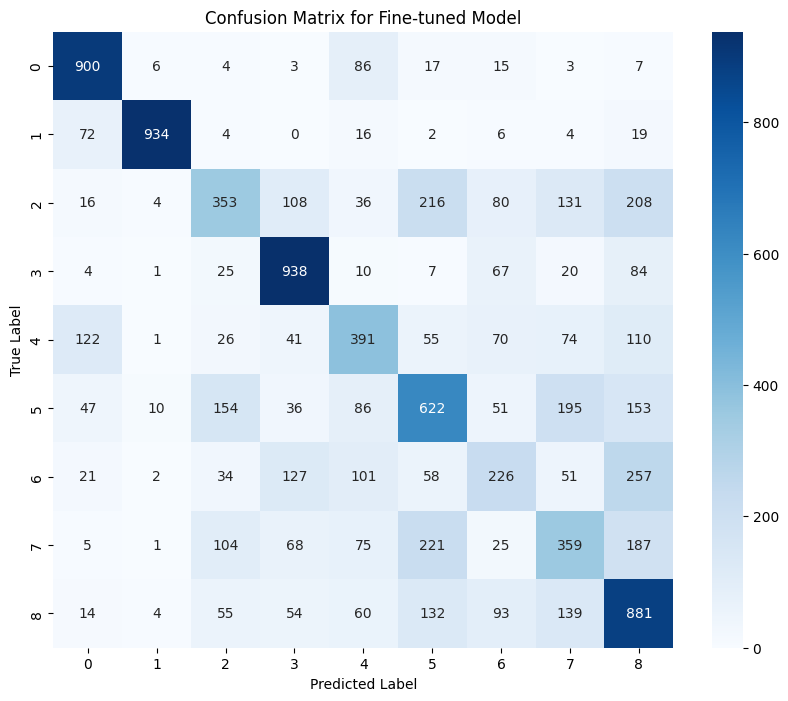

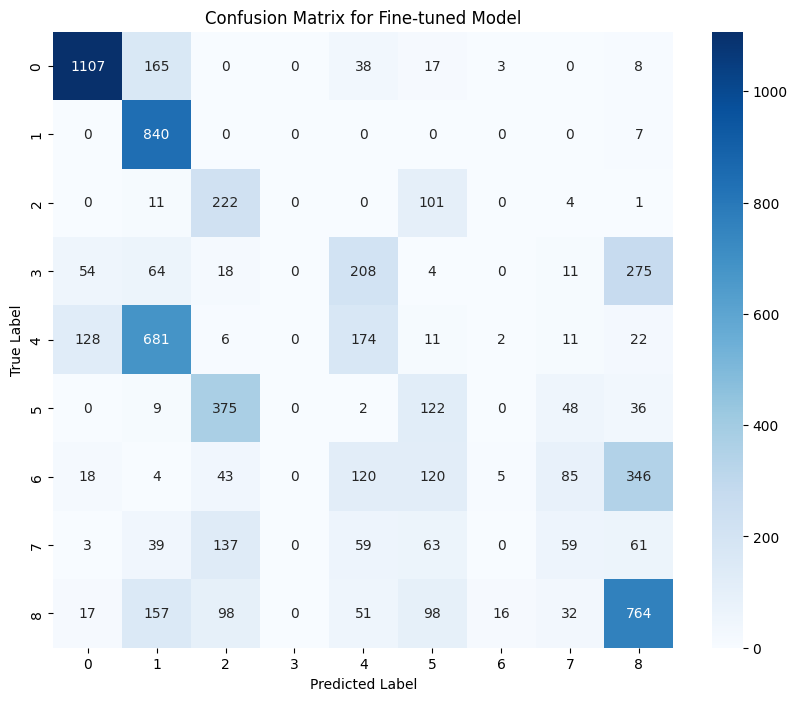

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Fine-tuned Model')
    plt.show()

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 加载最佳模型权重
fine_tune_model.load_state_dict(best_model_weights)

# 评估模型并获取预测标签
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# 在验证集上评估并绘制混淆矩阵
y_val_true, y_val_pred = get_predictions(linear_probe_model, val_loader)
plot_confusion_matrix(y_val_true, y_val_pred, labels_fine_tuned)

# 在测试数据集上评估并绘制混淆矩阵
y_test_true, y_test_pred = get_predictions(linear_probe_model, test_loader)
plot_confusion_matrix(y_test_true, y_test_pred, labels_fine_tuned)


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
'''
# Calculate confusion matrix
cm = confusion_matrix(y_val_fine_tuned, y_pred_fine_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_fine_tuned), yticklabels=np.unique(labels_fine_tuned))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-tuned Model')
plt.show()'''

"\n# Calculate confusion matrix\ncm = confusion_matrix(y_val_fine_tuned, y_pred_fine_tuned)\n\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_fine_tuned), yticklabels=np.unique(labels_fine_tuned))\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label')\nplt.title('Confusion Matrix for Fine-tuned Model')\nplt.show()"

2024-06-15 16:30:45.706680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 16:30:45.706777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 16:30:45.837917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


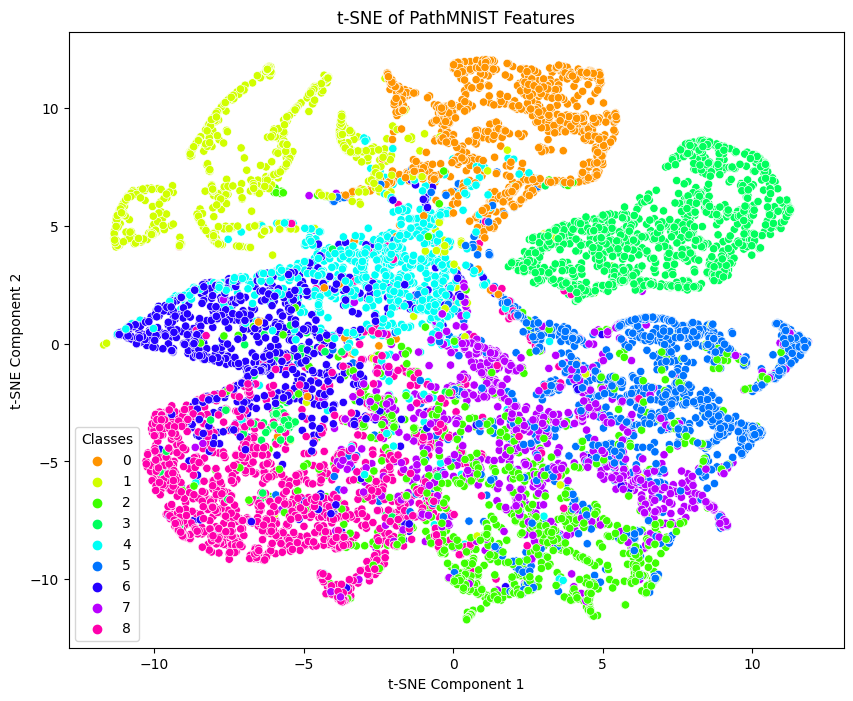

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap

data = np.load('pathmnist_features_fine_tuned-1.npz')
'''features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()'''
features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


#### We use 10% of the training data for fine-tuning

In [23]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 10% of training data for fine-tuning
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tuning 和验证过程
best_val_accuracy = 0.0
best_model_weights = None
fine_tune_epochs = 50

for epoch in range(fine_tune_epochs):
    fine_tune_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer_fine_tune.zero_grad()
        logits = fine_tune_model(data)
        loss = criterion_fine_tune(logits, target)
        loss.backward()
        optimizer_fine_tune.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    val_loss, val_accuracy = validate(fine_tune_model, val_loader, criterion_fine_tune)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = fine_tune_model.state_dict()

# 加载最佳模型权重
fine_tune_model.load_state_dict(best_model_weights)

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 在测试数据集上评估
test_accuracy = evaluate(fine_tune_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.3088767528533936
Fine-tune Epoch 0, Batch 10, Loss: 2.1808793544769287
Fine-tune Epoch 0, Batch 20, Loss: 2.1741292476654053
Fine-tune Epoch 0, Batch 30, Loss: 2.181246042251587


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fine-tune Epoch 0, Train Loss: 2.1875790092680187, Validation Loss: 2.155763381719589, Validation Accuracy: 0.24080367852858856
Fine-tune Epoch 1, Batch 0, Loss: 2.1471307277679443
Fine-tune Epoch 1, Batch 10, Loss: 2.1072473526000977
Fine-tune Epoch 1, Batch 20, Loss: 1.9590840339660645
Fine-tune Epoch 1, Batch 30, Loss: 1.7025614976882935
Fine-tune Epoch 1, Train Loss: 1.9470971061123743, Validation Loss: 1.8482089549303056, Validation Accuracy: 0.5609756097560976
Fine-tune Epoch 2, Batch 0, Loss: 1.493621587753296
Fine-tune Epoch 2, Batch 10, Loss: 1.3423254489898682
Fine-tune Epoch 2, Batch 20, Loss: 1.0750048160552979
Fine-tune Epoch 2, Batch 30, Loss: 0.953701376914978
Fine-tune Epoch 2, Train Loss: 1.2020749515957303, Validation Loss: 1.0156590953469276, Validation Accuracy: 0.6635345861655337
Fine-tune Epoch 3, Batch 0, Loss: 0.9625095725059509
Fine-tune Epoch 3, Batch 10, Loss: 0.9499362111091614
Fine-tune Epoch 3, Batch 20, Loss: 0.8196657299995422
Fine-tune Epoch 3, Batch 30

In [24]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')
'''
# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
#print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')'''

"\n# Load features\ndata_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')\nfeatures_fine_tuned = data_fine_tuned['features']\nlabels_fine_tuned = data_fine_tuned['labels']\n\n# Split data into training and testing sets\nX_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)\n\n# Standardize the features\nscaler_fine_tuned = StandardScaler()\nX_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)\nX_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)\n\n# Train logistic regression classifier\nclassifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)\nclassifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)\n\n# Predict on validation set\ny_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)\n\n# Calculate accuracy\n#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)\n#print(f'Fi

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


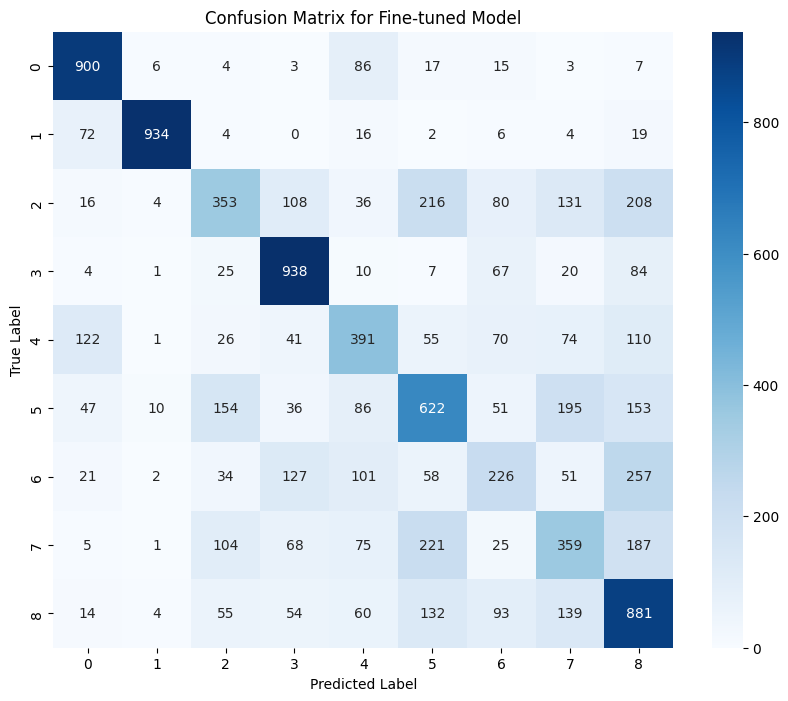

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


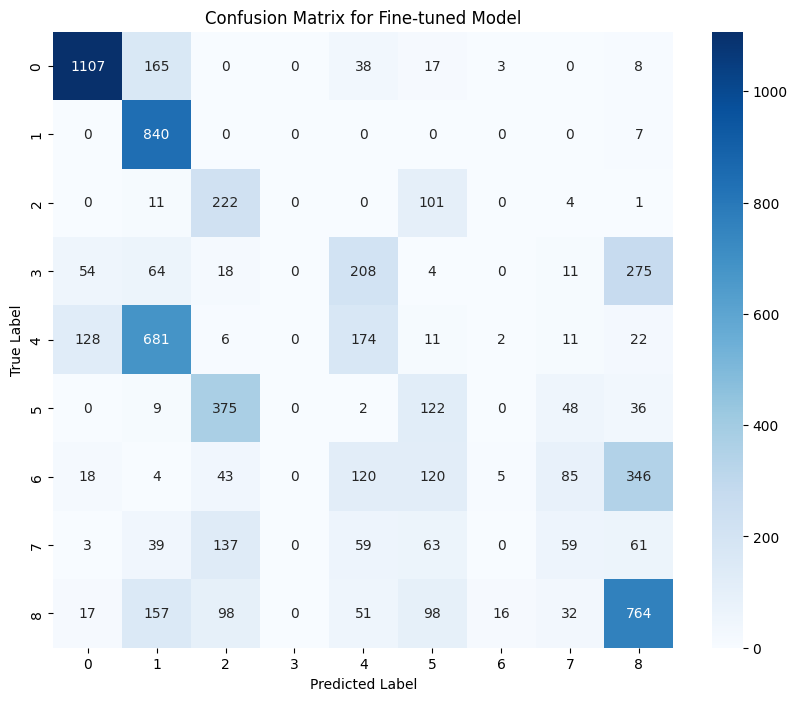

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Fine-tuned Model')
    plt.show()

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 加载最佳模型权重
fine_tune_model.load_state_dict(best_model_weights)

# 评估模型并获取预测标签
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# 在验证集上评估并绘制混淆矩阵
y_val_true, y_val_pred = get_predictions(linear_probe_model, val_loader)
plot_confusion_matrix(y_val_true, y_val_pred, labels_fine_tuned)

# 在测试数据集上评估并绘制混淆矩阵
y_test_true, y_test_pred = get_predictions(linear_probe_model, test_loader)
plot_confusion_matrix(y_test_true, y_test_pred, labels_fine_tuned)


In [ ]:
# Calculate confusion matrix
'''cm = confusion_matrix(y_val_fine_tuned, y_pred_fine_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_fine_tuned), yticklabels=np.unique(labels_fine_tuned))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-tuned Model')
plt.show()'''

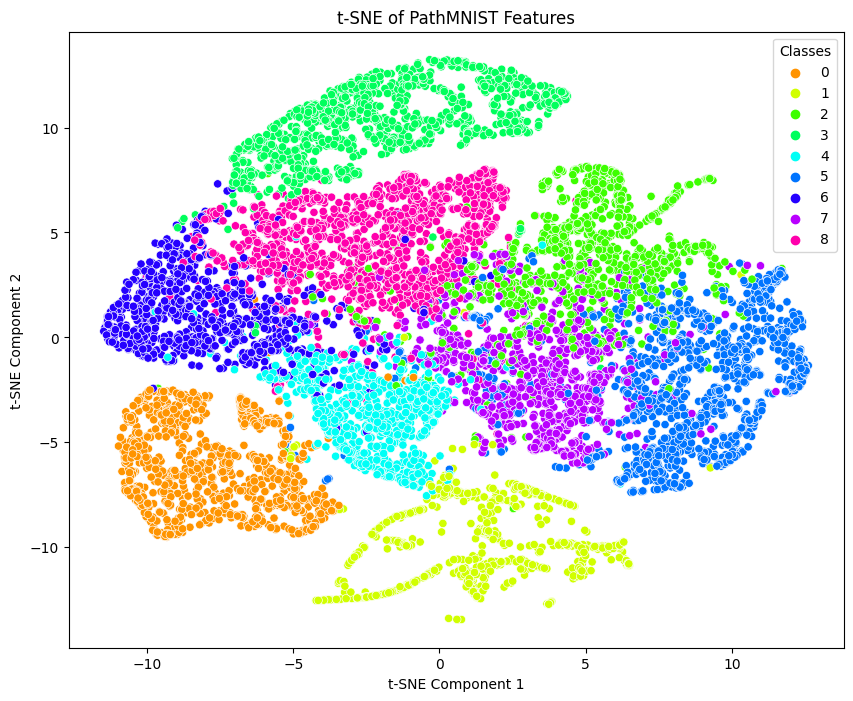

In [26]:
data = np.load('pathmnist_features_fine_tuned.npz')
'''features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 10% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()'''

features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


---

#### We extract 100% of training data for fine-tuning

In [27]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 100% of training data for fine-tuning

# np.random.seed(42)
# fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)

num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)


# Fine-tuning 和验证过程
best_val_accuracy = 0.0
best_model_weights = None
fine_tune_epochs = 50

for epoch in range(fine_tune_epochs):
    fine_tune_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer_fine_tune.zero_grad()
        logits = fine_tune_model(data)
        loss = criterion_fine_tune(logits, target)
        loss.backward()
        optimizer_fine_tune.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    val_loss, val_accuracy = validate(fine_tune_model, val_loader, criterion_fine_tune)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = fine_tune_model.state_dict()

# 加载最佳模型权重
fine_tune_model.load_state_dict(best_model_weights)

# 测试数据集
test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 在测试数据集上评估
test_accuracy = evaluate(fine_tune_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.2940802574157715
Fine-tune Epoch 0, Batch 10, Loss: 2.181781053543091
Fine-tune Epoch 0, Batch 20, Loss: 2.1778292655944824
Fine-tune Epoch 0, Batch 30, Loss: 2.192944049835205
Fine-tune Epoch 0, Batch 40, Loss: 2.1194283962249756
Fine-tune Epoch 0, Batch 50, Loss: 2.0461456775665283
Fine-tune Epoch 0, Batch 60, Loss: 1.9536925554275513
Fine-tune Epoch 0, Batch 70, Loss: 1.6386433839797974
Fine-tune Epoch 0, Batch 80, Loss: 1.3962374925613403
Fine-tune Epoch 0, Batch 90, Loss: 1.1906694173812866
Fine-tune Epoch 0, Batch 100, Loss: 0.8831925392150879
Fine-tune Epoch 0, Batch 110, Loss: 0.9550929069519043
Fine-tune Epoch 0, Batch 120, Loss: 0.7730348110198975
Fine-tune Epoch 0, Batch 130, Loss: 0.7651031017303467
Fine-tune Epoch 0, Batch 140, Loss: 0.7113134860992432
Fine-tune Epoch 0, Batch 150, Loss: 0.6967748999595642
Fine-tune Epoch 0, Batch 160, Loss: 0.7129878401756287
Fine-tune Epoch 0, Batch 170, Loss: 0.6449124813079834
Fine-tune Epoch 0, Batc

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fine-tune Epoch 0, Train Loss: 0.9950529026206244, Validation Loss: 0.5001892298460007, Validation Accuracy: 0.8223710515793683
Fine-tune Epoch 1, Batch 0, Loss: 0.5022910237312317
Fine-tune Epoch 1, Batch 10, Loss: 0.5404625535011292
Fine-tune Epoch 1, Batch 20, Loss: 0.44803014397621155
Fine-tune Epoch 1, Batch 30, Loss: 0.43304798007011414
Fine-tune Epoch 1, Batch 40, Loss: 0.4559081196784973
Fine-tune Epoch 1, Batch 50, Loss: 0.4548102021217346
Fine-tune Epoch 1, Batch 60, Loss: 0.4570128619670868
Fine-tune Epoch 1, Batch 70, Loss: 0.3758348524570465
Fine-tune Epoch 1, Batch 80, Loss: 0.47962287068367004
Fine-tune Epoch 1, Batch 90, Loss: 0.4107059836387634
Fine-tune Epoch 1, Batch 100, Loss: 0.48515570163726807
Fine-tune Epoch 1, Batch 110, Loss: 0.428414523601532
Fine-tune Epoch 1, Batch 120, Loss: 0.5351355671882629
Fine-tune Epoch 1, Batch 130, Loss: 0.49750518798828125
Fine-tune Epoch 1, Batch 140, Loss: 0.34190472960472107
Fine-tune Epoch 1, Batch 150, Loss: 0.459386944770813

In [28]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned_100.npz')
'''
# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned_100.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
#print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')'''

"\n# Load features\ndata_fine_tuned = np.load('pathmnist_features_fine_tuned_100.npz')\nfeatures_fine_tuned = data_fine_tuned['features']\nlabels_fine_tuned = data_fine_tuned['labels']\n\n# Split data into training and testing sets\nX_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)\n\n# Standardize the features\nscaler_fine_tuned = StandardScaler()\nX_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)\nX_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)\n\n# Train logistic regression classifier\nclassifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)\nclassifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)\n\n# Predict on validation set\ny_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)\n\n# Calculate accuracy\n#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)\n#print(

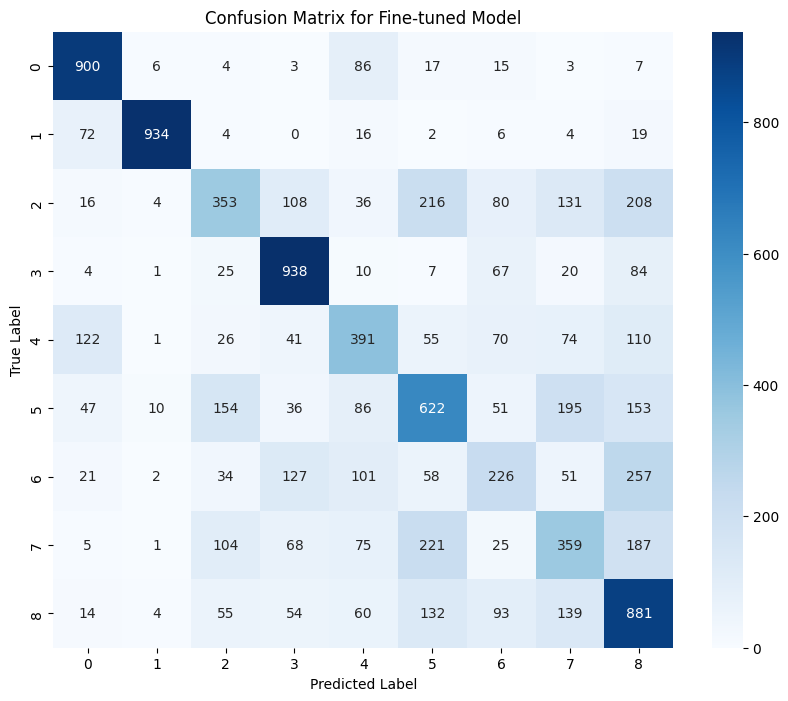

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


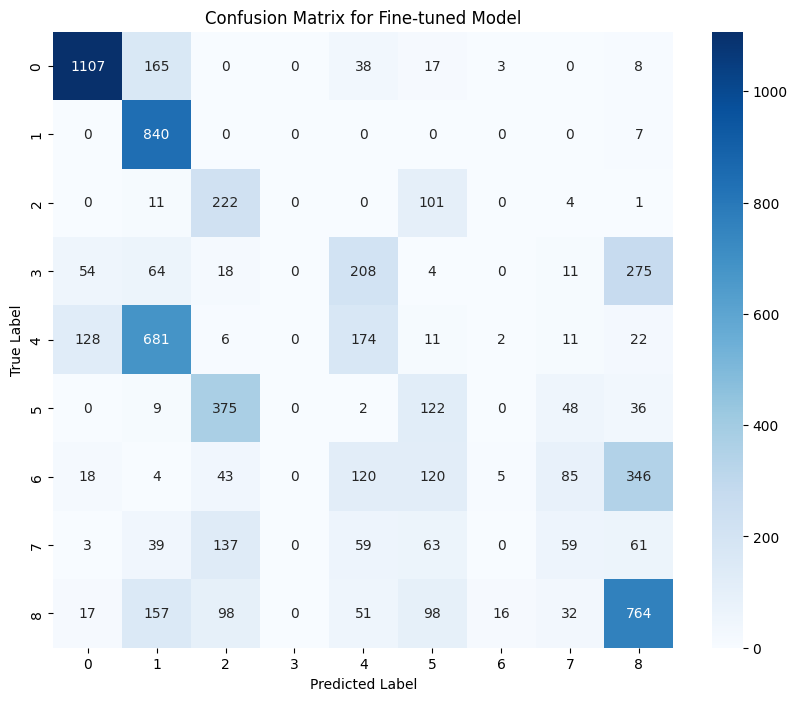

In [29]:
# 加载最佳模型权重
fine_tune_model.load_state_dict(best_model_weights)
# 在验证集上评估并绘制混淆矩阵
y_val_true, y_val_pred = get_predictions(linear_probe_model, val_loader)
plot_confusion_matrix(y_val_true, y_val_pred, labels_fine_tuned)

# 在测试数据集上评估并绘制混淆矩阵
y_test_true, y_test_pred = get_predictions(linear_probe_model, test_loader)
plot_confusion_matrix(y_test_true, y_test_pred, labels_fine_tuned)


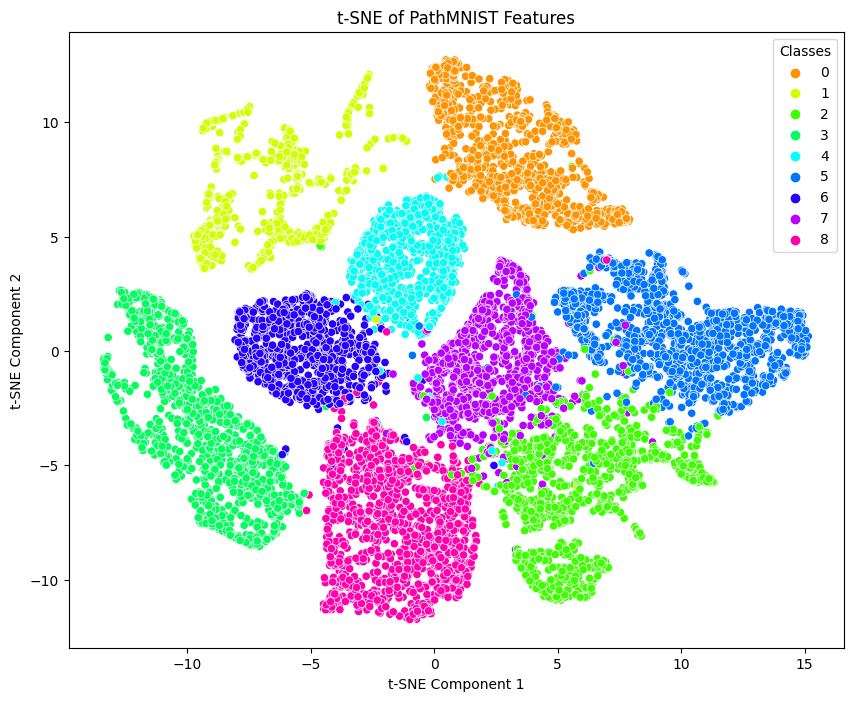

In [30]:
data = np.load('pathmnist_features_fine_tuned_100.npz')
'''features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 100% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()'''

features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


------

## Random Drafts

In [ ]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode

class_indices = {}

# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)

for i, data in enumerate(org_train_dataset): 
    class_idx = int(data[1][0])
    if class_idx not in class_indices:
        class_indices[class_idx] = []
    class_indices[class_idx].append(i)

# print(class_indices)

In [ ]:
def get_sub_indices(dataset, proportion=0.01):
    class_indices = {}
    
    for i, data in enumerate(dataset): 
        class_idx = int(data[1][0])
        if class_idx not in class_indices:
            class_indices[class_idx] = []
        class_indices[class_idx].append(i)
    
    # List to store subset indices
    subset_indices = []
        
    # Choose proportionate indices from each class
    for indices in class_indices.values():
        selected_indices = np.random.choice(
            indices, 
            size=int(np.ceil(len(indices) * proportion)),
            replace=False
        ).tolist()  # Ensure indices are in a list format
        subset_indices.extend(selected_indices)

    return subset_indices
        

In [ ]:
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)
print(fine_tune_indices)
print(len(fine_tune_indices))

In [ ]:
proportion = 0.1

In [ ]:
# List to store subset indices
subset_indices = []

np.random.seed(42)

# Choose proportionate indices from each class
for indices in class_indices.values():
    selected_indices = np.random.choice(
        indices, 
        size=int(np.ceil(len(indices) * proportion)),
        replace=False
    ).tolist()  # Ensure indices are in a list format
    subset_indices.extend(selected_indices)

print(subset_indices)

In [ ]:
len(subset_indices)

In [ ]:
len(org_train_dataset)

In [ ]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)

indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples * 0.01)
fine_tune_indices = indices[:fine_tune_size]

print(fine_tune_indices)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)